# Inspection DATA


In [3]:
# Importing the libraries 
import pandas as pd
import requests
import json
import numpy as np
from pandas import json_normalize
from google.cloud import storage

# Create a Data Frame of the NYC Open Data Set

df = pd.read_json('https://data.cityofnewyork.us/resource/43nn-pn8j')
#insp_data = pd.read_csv('DOHMH_New_York_City_Restaurant_Inspection_Results.csv')

In [ ]:
df.head()

In [ ]:
df.info()

# Missing data


In [ ]:
# To check if there are null values, returns the number of missing values:
df.isnull().sum()

In [ ]:
# To remove some columns from the inspection data set, that we do not mandatory need:
df.drop(columns = ['bin', 'bbl', 'nta','census_tract','council_district', 'community_board'],  inplace = True, axis=1)
df.head()

In [2]:


ins_data_API= requests.get('https://data.cityofnewyork.us/resource/qgea-i56i.json')
print(ins_data_API.text)

NameError: name 'requests' is not defined

# YELP data


In [ ]:
yelp_API= requests.get('https://api.yelp.com/v3/autocomplete?text=del&latitude=37.786882&longitude=-122.399972')
print(yelp_API.text)

In [ ]:
# Our script

# Create a Data Frame of the NYC Open Data Set

df = pd.read_json('https://data.cityofnewyork.us/resource/43nn-pn8j')

# Create Arrays and lists for the search / reference values of the above data set

restaurant_camis_codes = np.array(df['camis'].values)
phone_numbers = np.array(df['phone'].values)

# Format all phone numbers with +1

formatted_phone_numbers = []
for n in phone_numbers:
    formatted_phone_numbers.append("+1" + str(n))

# Create an empty list to store responses from Yelp

rows_of_businesses = []

# Connect to Yelp Developer Portal

api_key = 'BvKkbpeekLackRz9xTwV2clc0B90zBCDrS02mWb1-lf1nry6UIi7oCXQtBVBeTD7o9dbNHO42vbwEX2xrbnQZNCF1VGIpTT0sMUORvT81TjZjQ1g9SIGuWIciQwmZHYx'


# Write a function that connects to Yelp and returns business data by phone number from the NYC Open Data Set

def get_yelp_business_data(phone):
    url = "https://api.yelp.com/v3/businesses/search/phone?"
    headers = {'Authorization': 'Bearer %s' % api_key}
    params = {'phone': phone}
    review_data = requests.get(url, params=params, headers=headers)
    if review_data.status_code == 200:
        dict1 = review_data.json()
        df2 = json_normalize(dict1['businesses'])
        return df2
    else:
        print("The connection was unsuccessful for phone: ", phone, " .")
        empty_df = pd.DataFrame()
        return empty_df
        # If the response is unsuccessful, do not return anything for that query


# Create a loop that iterates over each restaurant camis code, retrieves the corresponding phone number, queries that
# phone number through the Yelp API, and stores it in a list (1) OR Utilize a range to limit how many calls you make
# per day. (2)

# 1

# for i in restaurant_camis_codes:
#     position = np.where(restaurant_camis_codes == i)[0][0]
#     sample_row = get_yelp_business_data(formatted_phone_numbers[position])
#     rows_of_businesses.append(sample_row)

# 2
# Get the first 999 businesses, or however many you select in the range

df_yelp_businesses = pd.DataFrame()
list_of_ids_dfs = []

for i in range(0, 999):
    sample_df = get_yelp_business_data(formatted_phone_numbers[i])
    if not sample_df.empty:
        list_of_ids_dfs.append(sample_df)

df_yelp_businesses = pd.concat(list_of_ids_dfs)
print(df_yelp_businesses)

# Get a CSV export of each data frame (you only need the inspection data once)

df.to_csv(r'C:\Users\brand\OneDrive\Desktop\Python Scripts\nyc_open_data_inspections.csv', index=False)
df_yelp_businesses.to_csv(r'C:\Users\brand\OneDrive\Desktop\Python Scripts\yelp_business_data_1.csv',
                          index=False)

list_of_file_names = ['nyc_open_data_inspections.csv', 'yelp_business_data_1.csv']

## Part 2: upload the files to the google cloud storage. The file names and the list of file names need to be altered
## for each run of the script.

client = storage.Client.from_service_account_json(json_credentials_path='eternal-dynamo-385016-0d75dccba94e.json')
bucket = storage.Bucket(client, 'cis_4400_group3')


def upload_to_bucket(file_name):
    blob = bucket.blob(file_name)
    blob.upload_from_filename(file_name)
    return "DONE"


for file in list_of_file_names:
    upload_to_bucket(file)
    print(file, 'has been uploaded to Google Cloud Storage')

In [ ]:
df_yelp_businesses["phone"].head()

In [4]:
# read the 2 files created
df_yelp= pd.read_csv('yelp_script.csv')
df_yelp.head()

,id,alias,name,image_url,is_closed,url,review_count,categories,rating,transactions,...,coordinates.longitude,location.address1,location.address2,location.address3,location.city,location.zip_code,location.country,location.state,location.display_address,price
0,QgClXDNikG0wRpIZ-Rcm7A,la-devozione-new-york,La Devozione,https://s3-media0.fl.yelpcdn.com/bphoto/y5BHHh...,False,https://www.yelp.com/biz/la-devozione-new-york...,62,"[{'alias': 'italian', 'title': 'Italian'}, {'a...",3.5,[],...,-74.005958,75 9th Ave,NaN,NaN,New York,10011.0,US,NY,"['75 9th Ave', 'New York, NY 10011']",NaN
1,LuhrC10hiTAQ6QRiAWhIGw,streat-food-san-antonio,StrEAT Food,https://s3-media0.fl.yelpcdn.com/bphoto/rMuRa3...,True,https://www.yelp.com/biz/streat-food-san-anton...,10,"[{'alias': 'streetvendors', 'title': 'Street V...",4.0,[],...,-98.466830,8123 Broadway,NaN,NaN,San Antonio,78209.0,US,TX,"['8123 Broadway', 'San Antonio, TX 78209']",$
2,ufKvMQK3mFV6iAvSwHBxXg,after-hours-theater-los-angeles,After Hours Theater,https://s3-media0.fl.yelpcdn.com/bphoto/rBfOnE...,False,https://www.yelp.com/biz/after-hours-theater-l...,1,"[{'alias': 'theater', 'title': 'Performing Art...",5.0,[],...,-118.245500,NaN,NaN,NaN,Los Angeles,NaN,US,CA,"['Los Angeles, CA']",NaN
3,gxWZGieYEeBYypsdK3cNow,emily-l-chou-md-san-diego,"Emily L Chou, MD",https://s3-media0.fl.yelpcdn.com/bphoto/uYjr4C...,False,https://www.yelp.com/biz/emily-l-chou-md-san-d...,1,"[{'alias': 'internalmed', 'title': 'Internal M...",5.0,[],...,-117.229607,Kaiser Permanente Carmel Valley Medical Office U,3851 Shaw Ridge Rd,NaN,San Diego,92130.0,US,CA,['Kaiser Permanente Carmel Valley Medical Offi...,NaN
4,Xf-ARD29oyoqXBWytgnAbQ,ai-t-quach-md-san-diego,"Ai T Quach, MD",https://s3-media0.fl.yelpcdn.com/bphoto/E14GNI...,False,https://www.yelp.com/biz/ai-t-quach-md-san-die...,1,"[{'alias': 'physicians', 'title': 'Doctors'}]",5.0,[],...,-117.164677,Kaiser Permanente Carmel Valley Medical Office U,3851 Shaw Ridge Rd,NaN,San Diego,92111.0,US,CA,['Kaiser Permanente Carmel Valley Medical Offi...,NaN


In [5]:
df_insp=pd.read_csv("nyc_inspections.csv")
df_insp.head()

,camis,boro,building,street,zipcode,phone,inspection_date,critical_flag,record_date,latitude,...,nta,dba,cuisine_description,action,score,grade,grade_date,inspection_type,violation_code,violation_description
0,50124794,Brooklyn,745,NOSTRAND AVENUE,11216.0,6468861881,1900-01-01T00:00:00.000,Not Applicable,2023-05-07T06:00:11.000,40.671908,...,BK61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,50126102,0,NaN,NaN,NaN,6464009665,1900-01-01T00:00:00.000,Not Applicable,2023-05-07T06:00:11.000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,50123719,Brooklyn,200,WYCKOFF AVENUE,11237.0,19178701708,1900-01-01T00:00:00.000,Not Applicable,2023-05-07T06:00:11.000,40.701668,...,BK77,SWEET AND DELICIOUS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,50117118,Manhattan,75,9 AVENUE,10011.0,6467200215,1900-01-01T00:00:00.000,Not Applicable,2023-05-07T06:00:11.000,40.741869,...,MN13,LA DEVOZIONE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,50113237,Brooklyn,5702,18 AVENUE,11204.0,7186868100,1900-01-01T00:00:00.000,Not Applicable,2023-05-07T06:00:11.000,40.623662,...,BK88,ORCHIDEA SPARKS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# To remove some columns from the inspection data set, that we will not need:
df_insp.drop(columns = ['bin', 'bbl', 'nta','census_tract','council_district', 'community_board'],  inplace = True, axis=1)
df_insp.head()

,camis,boro,building,street,zipcode,phone,inspection_date,critical_flag,record_date,latitude,longitude,dba,cuisine_description,action,score,grade,grade_date,inspection_type,violation_code,violation_description
0,50124794,Brooklyn,745,NOSTRAND AVENUE,11216.0,6468861881,1900-01-01T00:00:00.000,Not Applicable,2023-05-07T06:00:11.000,40.671908,-73.950299,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,50126102,0,NaN,NaN,NaN,6464009665,1900-01-01T00:00:00.000,Not Applicable,2023-05-07T06:00:11.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,50123719,Brooklyn,200,WYCKOFF AVENUE,11237.0,19178701708,1900-01-01T00:00:00.000,Not Applicable,2023-05-07T06:00:11.000,40.701668,-73.914968,SWEET AND DELICIOUS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,50117118,Manhattan,75,9 AVENUE,10011.0,6467200215,1900-01-01T00:00:00.000,Not Applicable,2023-05-07T06:00:11.000,40.741869,-74.004713,LA DEVOZIONE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,50113237,Brooklyn,5702,18 AVENUE,11204.0,7186868100,1900-01-01T00:00:00.000,Not Applicable,2023-05-07T06:00:11.000,40.623662,-73.985630,ORCHIDEA SPARKS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# Remove some columns that we will not be working with:
df_yelp.drop(columns = ['alias','id', 'image_url', 'is_closed', 'url'], inplace = True, axis=1)
df_yelp.head()

,name,review_count,categories,rating,transactions,phone,display_phone,coordinates.latitude,coordinates.longitude,location.address1,location.address2,location.address3,location.city,location.zip_code,location.country,location.state,location.display_address,price
0,La Devozione,62,"[{'alias': 'italian', 'title': 'Italian'}, {'a...",3.5,[],16467200215,(646) 720-0215,40.742463,-74.005958,75 9th Ave,NaN,NaN,New York,10011.0,US,NY,"['75 9th Ave', 'New York, NY 10011']",NaN
1,StrEAT Food,10,"[{'alias': 'streetvendors', 'title': 'Street V...",4.0,[],19999999999,(999) 999-9999,29.510630,-98.466830,8123 Broadway,NaN,NaN,San Antonio,78209.0,US,TX,"['8123 Broadway', 'San Antonio, TX 78209']",$
2,After Hours Theater,1,"[{'alias': 'theater', 'title': 'Performing Art...",5.0,[],19999999999,(999) 999-9999,34.053610,-118.245500,NaN,NaN,NaN,Los Angeles,NaN,US,CA,"['Los Angeles, CA']",NaN
3,"Emily L Chou, MD",1,"[{'alias': 'internalmed', 'title': 'Internal M...",5.0,[],19999999999,(999) 999-9999,32.935159,-117.229607,Kaiser Permanente Carmel Valley Medical Office U,3851 Shaw Ridge Rd,NaN,San Diego,92130.0,US,CA,['Kaiser Permanente Carmel Valley Medical Offi...,NaN
4,"Ai T Quach, MD",1,"[{'alias': 'physicians', 'title': 'Doctors'}]",5.0,[],19999999999,(999) 999-9999,32.833500,-117.164677,Kaiser Permanente Carmel Valley Medical Office U,3851 Shaw Ridge Rd,NaN,San Diego,92111.0,US,CA,['Kaiser Permanente Carmel Valley Medical Offi...,NaN


# Data analysis/transformation

In [8]:
# Inspection data

# Need to change the inspection date column to datetime format:
df_insp['inspection_date'] = pd.to_datetime(df_insp['inspection_date'])

# To add a column that counts how many data entries have the same id (CAMIS) (and therefore represent the same restaurant, this way we count for dublicates):
df_insp['num_of_inspections'] = df_insp.groupby('camis')['camis'].transform('count')

# Sort values by name (DBA), id (CAMIS), and inspection date:
df_insp_sorted = df_insp.sort_values(by=['dba', 'camis','inspection_date'])

# To Drop duplicate values:
df_insp_filtered = df_insp_sorted.drop_duplicates(subset=['dba', 'camis'], keep='last', inplace=False).copy()

# To Double check  if no duplicates remained:
df_insp_filtered['count_check'] = df_insp_filtered.groupby('camis')['camis'].transform('count')

print('Number of Restaurants in NYC: ', len(df_insp_filtered))

print('Number of duplicates: ', len(df_insp_filtered[df_insp_filtered['count_check'] > 1]))
df_insp_filtered.reset_index(inplace=True, drop = True)

# to display the first 5 rows of the final dataframe
df_insp_filtered.head()

Number of Restaurants in NYC:  999
Number of duplicates:  0


,camis,boro,building,street,zipcode,phone,inspection_date,critical_flag,record_date,latitude,...,cuisine_description,action,score,grade,grade_date,inspection_type,violation_code,violation_description,num_of_inspections,count_check
0,50106464,Queens,14438,87TH AVE,11435.0,9176840703,1900-01-01,Not Applicable,2023-05-07T06:00:11.000,40.706793,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1
1,50076292,Brooklyn,7210,NEW UTRECHT AVENUE,11228.0,9296669989,2018-09-28,Not Applicable,2023-05-07T06:00:10.000,40.618050,...,Mexican,No violations were recorded at the time of thi...,NaN,NaN,NaN,Smoke-Free Air Act / Re-inspection,NaN,NaN,1,1
2,50119168,Queens,25306,ROCKAWAY BLVD,11422.0,9999999999,1900-01-01,Not Applicable,2023-05-07T06:00:11.000,40.636013,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1
3,50130973,Manhattan,325,AMSTERDAM AVENUE,10023.0,9146564534,1900-01-01,Not Applicable,2023-05-07T06:00:11.000,40.780744,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1
4,50121339,Brooklyn,327,VAN BRUNT STREET,11231.0,3477681447,1900-01-01,Not Applicable,2023-05-07T06:00:11.000,40.677970,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1


In [ ]:
# Now there are not any duplicates, we have 999 restaurants to work with.

# Exploratory Data Analysis (EDA)


In [11]:
# We will inspect the number of restaurant taht have been  given a inspection Grade, by each Borough

# To create a new dataframe that includes only the restaurants that have been given a grade:
df_insp_filtered_new = df_insp_filtered.loc[df_insp_filtered['grade'].isin(['A','B','C'])].copy()

# To print them in descending order by borough:
print('NUMBER of Restaurants given grade A, B, or C per Borough:','\n',"\n",
      df_insp_filtered_new['grade'].groupby(df_insp_filtered_new['boro']).count().sort_values(ascending=False))

NUMBER of Restaurants given grade A, B, or C per Borough: 
 
 boro
Manhattan        35
Queens           23
Brooklyn         17
Bronx             8
Staten Island     2
Name: grade, dtype: int64


In [ ]:
# An inspection score of 0 to 13 is an A, 14 to 27 points is a B, and 28 or more points is a C
# We see that many restaurants are not given any Grade, while Manhattan has the most grades and Staten Island the least.

In [ ]:
# We are curious to inspect also the grades given by city. We will vizualize it.


# Data Visualization

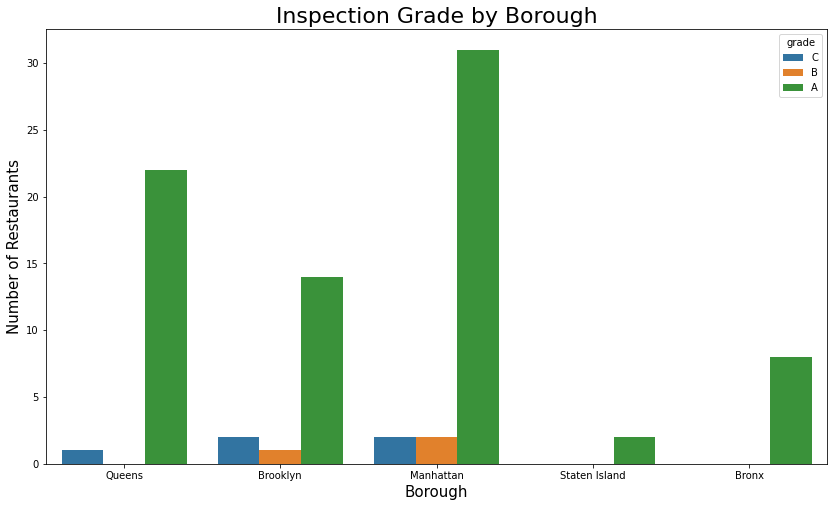

In [12]:
# Will display a bar chart to compare the number of each grade inspections per borough:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14,8))
df_insp_filtered_new=df_insp_filtered_new.sort_values("grade", ascending=False)
sns.countplot(data=df_insp_filtered_new, x='boro',hue='grade')
#df_insp_filtered_new=df_insp_filtered_new.sort_values("A")
plt.title('Inspection Grade by Borough', fontsize=22)
plt.xlabel('Borough', fontsize=15)
plt.ylabel('Number of Restaurants', fontsize=15);


Manhattan has the most A, followed by Queens that has 2nd most A, and then Brooklyn.

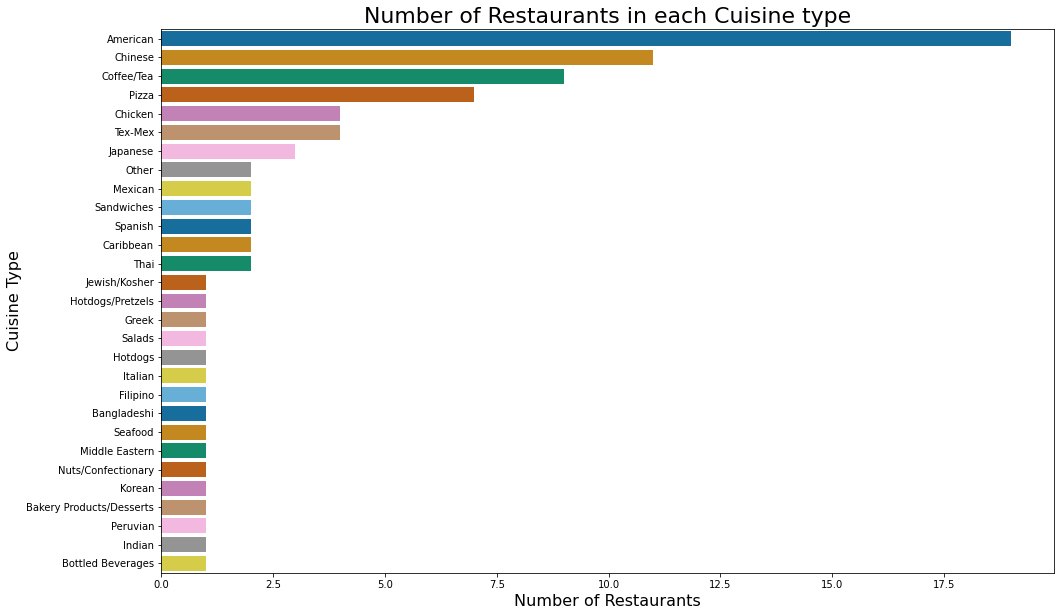

In [13]:
# Create a horizontal bar chart comparing the number of each grade inspections in each cuisine type:


plt.figure(figsize=(16,10))
sns.countplot(data=df_insp_filtered_new, y='cuisine_description', 
              order = df_insp_filtered_new['cuisine_description'].value_counts().index,palette='colorblind')

# Add chart title and labels
plt.title('Number of Restaurants in each Cuisine type', fontsize=22)
plt.xlabel('Number of Restaurants', fontsize=16)
plt.ylabel('Cuisine Type', fontsize=16);

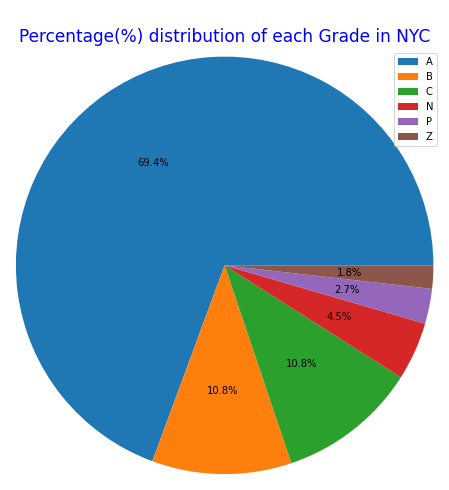

In [14]:
# To display  a pie chart that shows the breakout of each grade:
plt.figure(figsize=(14,8))
plt.pie(df_insp['grade'].value_counts(), autopct='%1.1f%%', radius=1.2)

plt.title('\nPercentage(%) distribution of each Grade in NYC', fontsize=17, color= "b");

plt.legend(["A", "B","C", "N","P", "Z"], )

plt.show()